In [ ]:
'''%pip install nltk
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install sklearn
%pip install nltk
%pip install gensim==4.3.3
%pip install wordcloud'''

import pandas as pd
import numpy as np
import string
import nltk
import gensim
import wordcloud

from nltk import PorterStemmer
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to c:\Users\fuzzi\AppData\Lo
[nltk_data]     cal\Programs\Python\Python311\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to c:\Users\fuzzi\AppData\Loca
[nltk_data]     l\Programs\Python\Python311\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to c:\Users\fuzzi\AppData\Lo
[nltk_data]     cal\Programs\Python\Python311\lib\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Reading the csv and merging the files into one based on title 

In [13]:
### Reading the files
df = pd.read_csv('data/english_grants.csv')
df_amt = pd.read_csv('raw data/CA.US-Social.csv', encoding='ISO-8859-1')
df.rename(columns={'Project title': 'Project_Title'}, inplace=True)
merged_df = pd.merge(df, df_amt, on='Project_Title', how ='left')
merged_df = merged_df[['Project_Title', 'CIHR contribution', 'CIHR_Contribution', 'Abstract/Summary' ]]
merged_df = merged_df.replace('nan', np.nan)
merged_df = merged_df.dropna()
merged_df['CIHR_Contribution'] = merged_df['CIHR_Contribution'].replace({'\$': '', ',': ''}, regex=True).astype(int)
merged_df['CIHR contribution'] = merged_df['CIHR contribution'].astype(int)

mismatched_indices = merged_df[merged_df['CIHR contribution'] != merged_df['CIHR_Contribution']].index
# Drop those rows
merged_df = merged_df.drop(mismatched_indices)  
merged_df = merged_df[merged_df['CIHR contribution'] != 0]

Preprocessing the text

In [14]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize

stop = set(stopwords.words('english'))
# custom_stopwords = {'de', 'et', 'le', 'à', 'de', 'la', 'en', 'santé', 'pour', 'dans'}
# stop.update(custom_stopwords)
punctuation = set(string.punctuation)
lemma = nltk.WordNetLemmatizer()

def clean(text):
    doc1 = text.lower()
    doc2 = doc1.split()
    doc3=[val for val in doc2 if val not in stop]
    doc4=" ".join([val for val in doc3]) 
    doc5=[val for val in doc4 if not val.isdigit()] #Exclude digits
    doc6="".join([val for val in doc5]) #compare to "".join(val for val in doc5)
    doc7=[val for val in doc6 if val not in punctuation]
    doc8="".join([val for val in doc7])
    doc9=doc8.split()
    doc10= [lemma.lemmatize(val) for val in doc9]
    doc11=" ".join([val for val in doc10])
    tokens = nltk.word_tokenize(doc11)
    return tokens

merged_df['clean_abstr'] = merged_df['Abstract/Summary'].apply(clean)
merged_df['Combined_text'] = merged_df['clean_abstr'].apply(lambda x: ' '.join(x))
clean_token = [token for tokens in merged_df['clean_abstr'] for token in tokens]



[nltk_data] Downloading package wordnet to c:\Users\fuzzi\AppData\Loca
[nltk_data]     l\Programs\Python\Python311\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Finding bigrams using gensim and creating a dictionary

In [15]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel


### COllocation
abstracts = merged_df['clean_abstr'].tolist()

##Finding bigrams
bigram = gensim.models.Phrases(merged_df['clean_abstr'], min_count=5, threshold=10)
bigram_model = gensim.models.phrases.Phraser(bigram)
merged_df['tokenized_bigrams'] = [bigram_model[doc] for doc in merged_df['clean_abstr']]
merged_df['Combined_bigram'] = merged_df['tokenized_bigrams'].apply(lambda x: ' '.join(x))

### Creating a dictionary and bag of words corpus
dictionary = Dictionary(merged_df['tokenized_bigrams'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in merged_df['tokenized_bigrams']]


Finding the optimum number of topics using coherence score for LDA

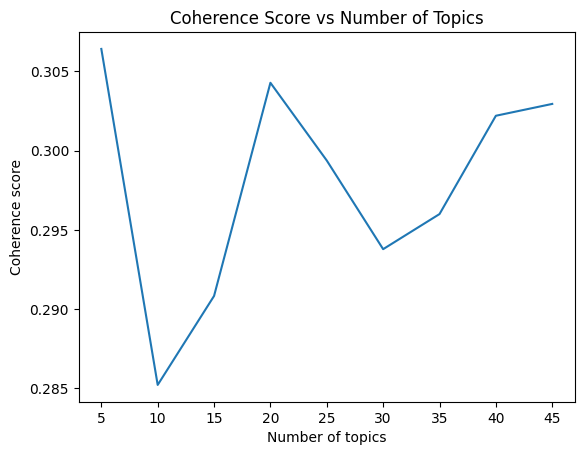

Optimal number of topics: 5
Topic 0: 0.010*"community" + 0.008*"older" + 0.006*"people" + 0.006*"may" + 0.006*"among" + 0.006*"cluster" + 0.005*"also" + 0.005*"risk" + 0.005*"experience" + 0.005*"neighbourhood"
Topic 1: 0.020*"asthma" + 0.013*"guideline" + 0.011*"canadian" + 0.010*"use" + 0.007*"intervention" + 0.007*"physical_activity" + 0.007*"project" + 0.006*"impact" + 0.006*"household_food" + 0.005*"prostate_cancer"
Topic 2: 0.016*"diabetes" + 0.008*"aboriginal" + 0.007*"ci" + 0.007*"community" + 0.006*"canada" + 0.006*"data" + 0.006*"canadian" + 0.006*"population" + 0.006*"program" + 0.006*"food"
Topic 3: 0.014*"youth" + 0.011*"experience" + 0.010*"mental_health" + 0.009*"treatment" + 0.008*"social" + 0.008*"service" + 0.007*"care" + 0.007*"canada" + 0.006*"impact" + 0.006*"refugee"
Topic 4: 0.014*"mental_health" + 0.011*"canadian" + 0.011*"child" + 0.010*"factor" + 0.008*"intervention" + 0.008*"data" + 0.007*"population" + 0.007*"school" + 0.007*"individual" + 0.006*"injury"
Top

In [16]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

topic_num = range(5, 50, 5)
coherence_score = []

### Evaluating coherence score for eahc number of topics
for num in topic_num:
    lda_model = LdaModel(corpus = bow_corpus, num_topics=num, id2word=dictionary,
                         random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=bow_corpus,
                                     texts=merged_df['tokenized_bigrams'], dictionary=dictionary, coherence='c_v')
    coherence_score.append(coherence_model.get_coherence())

### Plotting the coherence scores
plt.plot(topic_num, coherence_score)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

### Choose the optimal number of topics
optimal_topics = topic_num[coherence_score.index(max(coherence_score))]
print('Optimal number of topics:', optimal_topics)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


### LDA modeling
lda_model = LdaModel(bow_corpus, num_topics=optimal_topics, id2word=dictionary, random_state=42)
topic_distributions = [dict(lda_model.get_document_topics(bow)) for bow in bow_corpus]
topic_df = pd.DataFrame.from_records(topic_distributions).fillna(0)
topic_df.columns = [f"Topic_{i+1}" for i in range(optimal_topics)]
topic_df.index = merged_df.index
topic_df = topic_df.sort_index()
merged_df = merged_df.sort_index()
topic_df['Grant_Amount'] = merged_df['CIHR contribution']
### Categorizing the grant amount
labels = ['Very Small','Small', 'Moderate', 'Large', 'Very Large']
bins = [topic_df['Grant_Amount'].min(), 
        topic_df['Grant_Amount'].quantile(0.2), 
        topic_df['Grant_Amount'].quantile(0.4), 
        topic_df['Grant_Amount'].quantile(0.6), 
        topic_df['Grant_Amount'].quantile(0.8), 
        topic_df['Grant_Amount'].max()]


topic_df['funding_category'] = pd.cut(topic_df['Grant_Amount'], bins=bins, labels=labels, include_lowest=True)
category_order = {"Very Small": 1, "Small": 2, "Moderate": 3, "Large": 4, "Very Large": 5}
topic_df['category_numeric'] = topic_df['funding_category'].map(category_order)


Splitting the data into train and test

In [ ]:
X = topic_df.drop('funding_category', axis=1)  # Topic proportions as features
y = topic_df['funding_category']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Apply scaling to relevant features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Tuning the parameters and modeling


In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


results = {}
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
knn_model = KNeighborsClassifier()
lda_model = LinearDiscriminantAnalysis()
def train_and_evaluate(model, param_grid=None):
    if param_grid:  # Perform grid search if param_grid is provided
        if model in (logistic_model, knn_model, lda_model):
            grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
        else:
            grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)
    
    if model in (logistic_model, knn_model, lda_model):
        cv_score = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        print(f"Cross-validation accuracy: {cv_score:.4f}")
    # Cross-validation score
    else:
        cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()
        print(f"Cross-validation accuracy: {cv_score:.4f}")
        
    # Evaluate on test data
    if model in (logistic_model, knn_model, lda_model):
        y_pred = best_model.predict(X_test_scaled)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
    else:
        y_pred = best_model.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        
    return best_model, cv_score

# 1. Multinomial Logistic Regression
print("\n1. Multinomial Logistic Regression")
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
logistic_param_grid = {'C': [0.1, 1, 10]}  # Regularization parameter
results['Logistic Regression'] = train_and_evaluate(logistic_model, logistic_param_grid)

# 2. Decision Tree
print("\n2. Decision Tree")
tree_model = DecisionTreeClassifier(random_state=42)
tree_param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
results['Decision Tree'] = train_and_evaluate(tree_model, tree_param_grid)

# 3. Random Forest
print("\n3. Random Forest")
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]}
results['Random Forest'] = train_and_evaluate(rf_model, rf_param_grid)

# 4. Gradient Boosting
print("\n4. Gradient Boosting")
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
results['Gradient Boosting'] = train_and_evaluate(gb_model, gb_param_grid)

# 5. Naive Bayes
print("\n5. Naive Bayes")
nb_model = MultinomialNB()
nb_param_grid = {'alpha': [0.1, 1, 10]}  # Smoothing parameter
results['Naive Bayes'] = train_and_evaluate(nb_model, nb_param_grid)

# 6. k-Nearest Neighbors (k-NN)
print("\n6. k-Nearest Neighbors (k-NN)")
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
results['k-NN'] = train_and_evaluate(knn_model, knn_param_grid)

# 7. Linear Discriminant Analysis (LDA)
print("\n7. Linear Discriminant Analysis")
lda_model = LinearDiscriminantAnalysis()
lda_param_grid = None  # No hyperparameters to tune for LDA
results['LDA'] = train_and_evaluate(lda_model, lda_param_grid)

# Summary of cross-validation scores
print("\nSummary of Cross-Validation Scores:")
for model_name, (model, score) in results.items():
    print(f"{model_name}: {score:.4f}")


1. Multinomial Logistic Regression
Best parameters: {'C': 0.1}
Cross-validation accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

       Large       1.00      1.00      1.00       211
    Moderate       1.00      1.00      1.00       286
       Small       1.00      1.00      1.00       253
  Very Large       1.00      1.00      1.00       235
  Very Small       1.00      1.00      1.00       253

    accuracy                           1.00      1238
   macro avg       1.00      1.00      1.00      1238
weighted avg       1.00      1.00      1.00      1238

Confusion Matrix:
[[211   0   0   0   0]
 [  0 286   0   0   0]
 [  0   0 253   0   0]
 [  0   0   0 235   0]
 [  0   0   0   0 253]]

2. Decision Tree
Best parameters: {'max_depth': 3, 'min_samples_split': 2}
Cross-validation accuracy: 0.9998
Classification Report:
              precision    recall  f1-score   support

       Large       1.00      1.00      1.00       211
    Moderate  

c:\Users\fuzzi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
